### TODO
- Issues resolved
- Clean and complete text
- Removal of extra cells
- Better display of graphs
    - SVG but not cut off
    - HTML wrapper
    - Netron?
    - Or just CSS styling on the website?
- Is it _really_ attention? cf AFT paper
- Can we hit an endpoint running the reference implementation? HF?

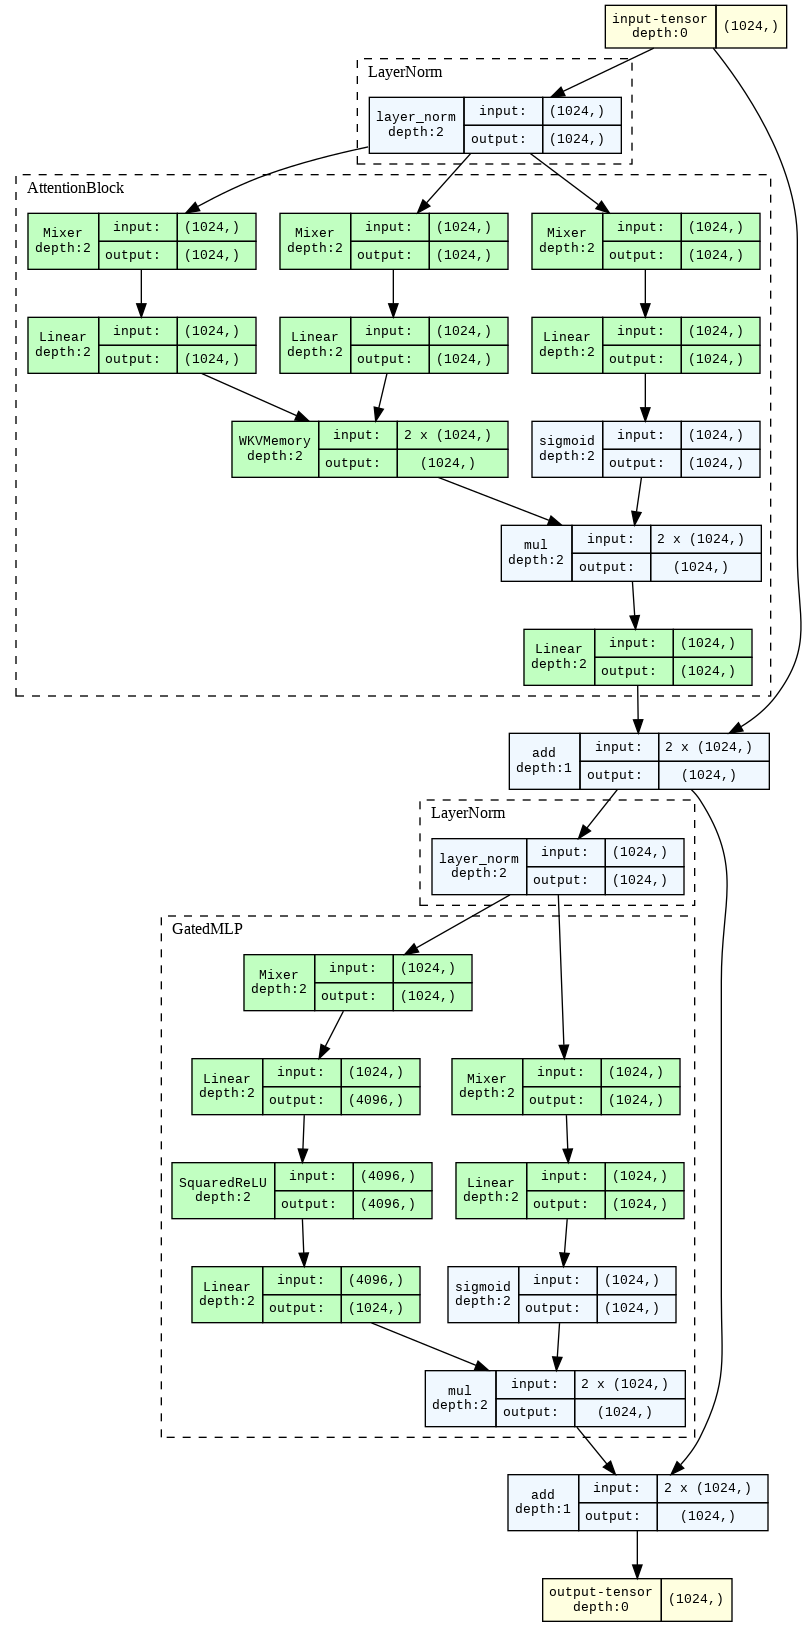

In [1]:
from IPython import display

display.Image("https://i.imgur.com/VTiPQTG.png")

# Why does this matter?

- RNNs are natural for sequence models
    - “Infinite” context
- But RNNs are not as data-efficient (see Kaplan et al. paper)
- Transformers are more data-efficient and are fast during training (because highly parallelizable), but that benefit doesn’t transfer to inference time
    - GPUs are less useful at inference time — batch size 1
- RWKV’s architecture cleverly uses exponentials to define memory so that they get both Transformer-style parallelization during training in a recurrent architecture
- RWKV paper and code hard to parse — single-letter variable names and non-standard nomenclature.

Took the code in [this post](https://johanwind.github.io/2023/03/23/rwkv_details.html)
and rewrote it
- in PyTorch
- using `Module`s
- step-by-step with visualizations

# Setup

## Installation and Imports

In [2]:
# install a package for handling text input to the model
%pip install -qqq tokenizers==0.13.3 1> /dev/null
# install packages for runtime typechecking of arrays
%pip install -qqq beartype==0.14.1 jaxtyping==0.2.20 1> /dev/null
# install a neat little package for visualizing PyTorch graphs
%pip install -qqq torchview==0.2.6 1> /dev/null

## Torch Setup

In [3]:
from jaxtyping import Float32, Float64
from jaxtyping import Int
import torch

# we're just talking about inference, so no need to calculate gradients
torch.autograd.set_grad_enabled(False)

# we use double-precision floats, accepting a big slow-down
# so that we can totally ignore numerical safety in favor of clarity.
# this is a tutorial, so our brains are the slow step.
torch.set_default_dtype(torch.float64)

# allows us to easily switch floating point types while still precisely type-checking tensors
# -- useful when debugging numerical issues!
if torch.get_default_dtype() == torch.float64:
    Float = Float64
else:
    Float = Float32

## Download and Setup Weights

In [4]:
from pathlib import Path

weights_path = Path("RWKV-4-Pile-430M-20220808-8066.pth")

if not weights_path.exists():
    !wget -q https://huggingface.co/BlinkDL/rwkv-4-pile-430m/resolve/main/{weights_path.name} 1> /dev/null

print(f"Loading {weights_path}")
weights = torch.load(weights_path, map_location="cpu")

Loading RWKV-4-Pile-430M-20220808-8066.pth


In [5]:
from typing import Dict


def remap_weights(weights: Dict[str, torch.Tensor]):
    """Renames the keys of the weights from the official implementation for clarity."""
    weights = dict(weights) # drop "ordered" property of dict
    keys = list(weights.keys())  # pull keys out so we can mutate the dict
    for key in keys:
        value = weights.pop(key)  # pull out the tensor and drop its name from the dict
        # and then change the name
        key = (key
        # unabbreviate some names
        .replace("emb.", "embedding.")
        .replace(".att.", ".attention.")
        # make some names clearer
        .replace("first", "log_gain")
        .replace("decay", "log_decay")
        # make some names more precise
        .replace(".ffn.", ".gated_mlp.")
        # unpack some parameters into modules, with unabbreviated names
        .replace("mix_r", "receptance_mixer.weight")
        .replace("mix_v", "value_mixer.weight")
        .replace("gated_mlp.time_mix_k", "gated_mlp.mlp_mixer.weight")
        .replace("attention.time_mix_k", "attention.key_mixer.weight")
        .replace("log_gain", "memory.log_gain")
        .replace("log_decay", "memory.log_decay")
        # rename the embedding and unembedding layers
        .replace("blocks.0.ln0", "ln_emb")
        .replace("ln_out", "ln_unemb")
        .replace("head.", "unembedding.")
        # drop the "time_" prefix
        .replace(".time_", ".")
        )

        # handle different transpose convention
        if key == "embedding.weight":
            value = value.T

        # reinsert name and tensor pair
        weights[key] = value

    return weights


for key in weights.keys():
    if ".time_" in key:
        weights[key] = weights[key].squeeze()
    weights[key] = weights[key].float()
weights = remap_weights(weights)

In [6]:
from tokenizers import Tokenizer

tokenizer_path = Path("20B_tokenizer.json")

if not tokenizer_path.exists():
    !wget -q https://raw.githubusercontent.com/BlinkDL/ChatRWKV/main/{tokenizer_path.name} 1> /dev/null

tokenizer = Tokenizer.from_file(str(tokenizer_path))

## Little Helpers

This little helper is what we use to pull the values from the saved weights into our custom layers.

In [7]:
class LoadingMixin:

    @classmethod
    def from_weights(cls, weights, *args, **kwargs):
        self = cls(*args, **kwargs)
        missing_keys, unexpected_keys = self.load_state_dict(weights, strict=False)
        assert not missing_keys, missing_keys
        return self

This little helper draws out a PyTorch module as a graph.

In [8]:
from typing import Optional

import IPython.display

import graphviz
import torchview

graphviz.set_jupyter_format("png")


def display_graph(module, depth: int=1, input_data: Optional[torch.Tensor]=None, graph_dir: str="LR"):
    """Displays the PyTorch module's graph when run on given input data."""
    if input_data is None:
        input_data = to_onehot(0)

    g = torchview.draw_graph(
        module, input_data=input_data,
        depth=depth, device="meta",
        expand_nested=True, graph_dir=graph_dir, hide_module_functions=False)

    IPython.display.display_png(g.visual_graph);

# Defining the External Interface: Autoregressive Sequence Modeling

Combine a new token with an existing state to predict the next token and update the state.

WTF is a token?

In [9]:
from collections.abc import Callable

TokenId = int

tokenizer.token_to_id: Callable[[str], TokenId]
id = tokenizer.token_to_id("Drosophila")

id

37815

In [10]:
print(tokenizer.id_to_token(id))

Drosophila


In [11]:
N_VOCAB = 50_277

token_id = N_VOCAB
if 0 <= token_id < N_VOCAB:
    assert tokenizer.id_to_token(N_VOCAB) is None
    print(f"index {token_id} is in vocab")
else:
    assert tokenizer.id_to_token(N_VOCAB) is None
    print(f"index {token_id} is not in vocab")

index 50277 is not in vocab


Two ways to represent: as an integer or as a vector.

Neural networks like vectors.

In [12]:
OneHot = Float[torch.Tensor, f"vocabSize={N_VOCAB}"]
TokenId = int | OneHot


def to_onehot(k: int) -> OneHot:
    out = torch.zeros(N_VOCAB)
    out[k] = 1.
    return out

to_onehot(1)

tensor([0., 1., 0.,  ..., 0., 0., 0.])

But Python type annotations are more like guidelines.

Let's bring in a runtime type checker!

`beartype` decorator.

In [13]:
from beartype import beartype

to_onehot = beartype(to_onehot)

to_onehot(N_VOCAB - 1)

tensor([0., 0., 0.,  ..., 0., 0., 1.])

A probabilistic model of language returns a distribution over possible future sequences.

In [14]:
NextTokenProbabilities = Float[torch.Tensor, f"vocabSize={N_VOCAB}"]

NextTokenProbabilities

jaxtyping.Float64[Tensor, 'vocabSize=50277']

In [15]:
class RWKVLM(torch.nn.Module):
    """A language model that uses RWKV."""

    @beartype
    def forward(self, token: TokenId) -> NextTokenProbabilities:
        token = to_onehot(token) if isinstance(token, int) else token

        # use that onehot to retrieve the token's vector representation
        embedded_token: Embedding = self.embedding(token)  # yes, DNN people really do say "embedding" this much

        # apply the "meat" of the model to enrich the embedding (with sequence context plus knowledge from the weights)
        sequence_embedding: Embedding = self.blocks(embedded_token)

        # use that to assigned probabilities to each possible next token
        probs: NextTokenProbabilities = self.unembedding(sequence_embedding)

        return probs


RWKVLM.forward

<function __main__.RWKVLM.forward(self, token: int | jaxtyping.Float64[Tensor, 'vocabSize=50277']) -> jaxtyping.Float64[Tensor, 'vocabSize=50277']>

But wait, we didn't define a `__init__`,
so how are we going to define the layers?

Fun trick: you can add methods to a class after defining it in Python!

We'll do this throughout the post so that we can focus on important details first.

In [16]:
def __init__(self, embedding_layer, rwkv, unembedding_layer):
    super(RWKVLM, self).__init__()
    self.embedding: TokenEmbedding = embedding_layer
    self.blocks: RWKV = rwkv
    self.unembedding: Unembedding = unembedding_layer

RWKVLM.__init__ = __init__

### Map tokens to embeddings: dense vectors

Dense vectors support vibes-based operations, like retrieval.

In [17]:
N_EMBD = 1024
Embedding = Float[torch.Tensor, f"channels={N_EMBD}"]
# aka channels, aka internal representation, aka hidden state, aka latents, aka "residual stream"

In [18]:
class TokenEmbedding(LoadingMixin, torch.nn.Module):
    """A layer that converts token IDs into vectors our network can understand."""
    @beartype
    def forward(self, token: TokenId) -> Embedding:
        token = to_onehot(token) if isinstance(token, int) else token
        embedded_token: Embedding = self.embedding(token)
        embedded_token = self.ln_emb(embedded_token)

        return embedded_token

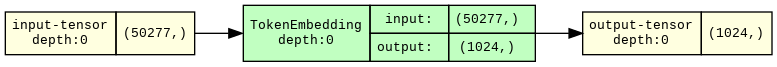

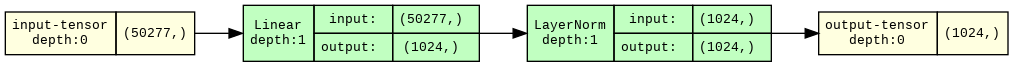

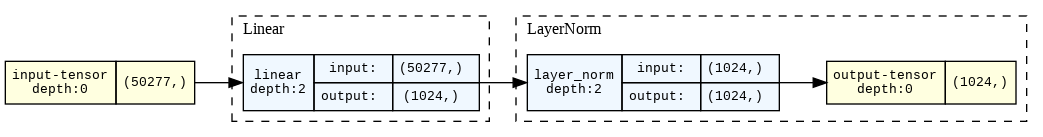

In [19]:
def __init__(self):
    super(TokenEmbedding, self).__init__()
    self.embedding = torch.nn.Linear(in_features=N_VOCAB, out_features=N_EMBD, bias=False)
    self.ln_emb = torch.nn.LayerNorm(N_EMBD)

TokenEmbedding.__init__ = __init__

for depth in range(3):
    display_graph(TokenEmbedding(), depth=depth)

In [20]:
embs = TokenEmbedding.from_weights(weights)

embs

TokenEmbedding(
  (embedding): Linear(in_features=50277, out_features=1024, bias=False)
  (ln_emb): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
)

In [21]:
out: Embedding = embs(0)
out

tensor([ 0.0204, -2.9601, -0.3523,  ..., -0.5697,  1.0452, -0.5205])

### Unembedding

Once we're done processing with our network,
we need to turn back into a probability distribution over tokens.

This is the `Unembedding` layer.

In [22]:
class Unembedding(LoadingMixin, torch.nn.Module):
    """A layer that converts our network's internal representation into a prediction."""

    @beartype
    def forward(self, x: Embedding) -> NextTokenProbabilities:
        x = self.ln_unemb(x)
        x = self.unembedding(x)

        probs: NextTokenProbabilities = torch.nn.functional.softmax(x, dim=-1)

        return probs

Pleasingly enough, it's like an embedding in reverse:

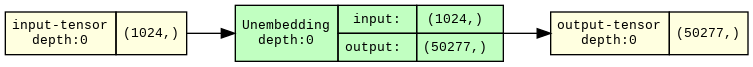

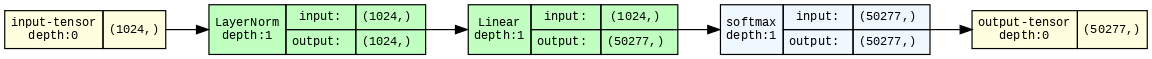

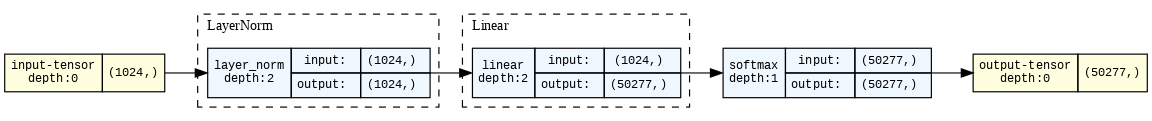

In [23]:
def __init__(self):
    super(Unembedding, self).__init__()
    self.ln_unemb = torch.nn.LayerNorm(N_EMBD)
    self.unembedding = torch.nn.Linear(in_features=N_EMBD, out_features=N_VOCAB, bias=False)

Unembedding.__init__ = __init__

for depth in range(3):
    display_graph(Unembedding(), depth=depth, input_data=torch.zeros(N_EMBD))

In [24]:
unembs = Unembedding.from_weights(weights)

unembs

Unembedding(
  (ln_unemb): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (unembedding): Linear(in_features=1024, out_features=50277, bias=False)
)

### A "zero-layer" RWKV

The simplest RWKV model has 0 blocks in the middle.

It's (up to normalization) equivalent to the zero-layer Transformer
and is just a linear model for predicting next tokens.

Pun: it's a maRWKV model.

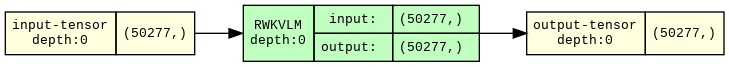

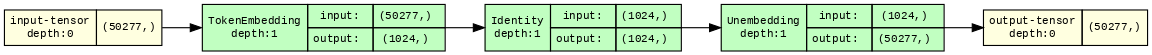

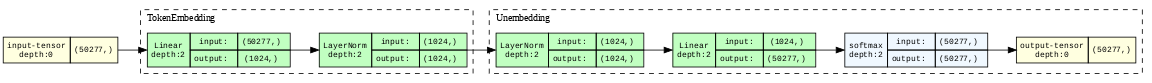

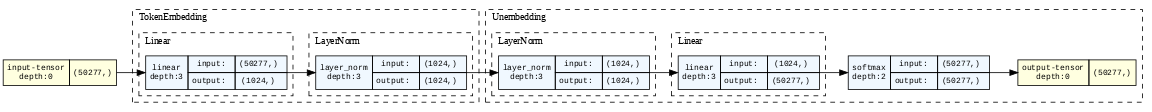

In [25]:
for depth in range(4):
    viz_marwkv = RWKVLM(TokenEmbedding(), torch.nn.Identity(), Unembedding())
    display_graph(viz_marwkv, depth=depth)

In [26]:
marwkv = RWKVLM(embs, torch.nn.Identity(), unembs)
marwkv

RWKVLM(
  (embedding): TokenEmbedding(
    (embedding): Linear(in_features=50277, out_features=1024, bias=False)
    (ln_emb): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (blocks): Identity()
  (unembedding): Unembedding(
    (ln_unemb): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (unembedding): Linear(in_features=1024, out_features=50277, bias=False)
  )
)

Let's see what happens when we run it:

In [27]:
inpt = "Drosophila"

inpt_id = tokenizer.token_to_id(inpt)
assert inpt_id is not None, f"{inpt} is not a token"

outs: NextTokenProbabilities = marwkv.forward(inpt_id)

outs

tensor([1.7324e-31, 1.1899e-23, 9.0729e-25,  ..., 2.1713e-29, 1.5557e-25,
        1.3370e-28])

Hmm, hard to parse.

What does the model "think" is coming next?

Let's take the most likely thing:

In [28]:
max_p_token_id: TokenId = torch.argmax(outs).item()
print(max_p_token_id)
print(f"{inpt}{tokenizer.decode([max_p_token_id])}")

15063
Drosophila melan


That looks like the beginning of the rest of the scientific name of _Drosophila melanogaster_,
the fruit fly species used in genetic research.

More generally, we want to sample:

In [29]:
import random

# TODO: break this down a bit more?
@beartype
def sample(probs: NextTokenProbabilities, temperature=1.0, top_p=1.0):
    if temperature == 0:
        return torch.argmax(probs).item()

    probs = probs.clone()  # work on a copy, rather than the original
    if top_p < 1.0:
        sorted_probs, sort_indices = torch.sort(probs, descending=True, stable=True)
        cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
        all_below_threshold, first_below_threshold = torch.max(cumulative_probs >= top_p, dim=-1)
        if not all_below_threshold:
            indices_of_bottom_p = sort_indices[first_below_threshold:]
            probs[indices_of_bottom_p] = 0.0

    probs = probs ** ( 1 / temperature)  # doesn't work with temperature == 0

    probs = probs / torch.sum(probs)

    return random.choices(range(len(probs)), weights=probs, k=1)[0]

In [30]:
print(inpt + tokenizer.decode([sample(marwkv(inpt_id), temperature=1.0)]))

Drosophila melan


The model is pretty certain ` melan` is coming next.

To see interesting behavior, let's see what happens when we feed the model back on itself.

In [31]:
# TODO: docstring? decompose?

def generate(self, context: str="", N: int=1, temperature=1.0, top_p=1.0, display: bool=True) -> NextTokenProbabilities:
    if display:
        print("Preprocessing context")
    for ii, token in enumerate(tokenizer.encode(context).ids):
        if display:
            streaming_print(tokenizer.decode([token]))
        next_token_probs = self(token)
    if len(context) == 0:
        next_token_probs = self(0)  # <|endoftext|>

    for ii in range(N):
        token = sample(next_token_probs, temperature=temperature, top_p=top_p)
        if display:
            streaming_print(tokenizer.decode([token]))
        next_token_probs = self(token)

    return next_token_probs

RWKVLM.generate = generate

In [32]:
def streaming_print(text: str):
    """Prints text immediately and without adding a newline."""
    print(text, end="", flush=True)

In [33]:
out = marwkv.generate(context="Drosophila", N=2, temperature=0.0)

Preprocessing context
Drosophila melanospor

`melanospor` is the beginning of another frequently-used scientific name:
`melanosporum`, the species name of the [French black truffle](https://en.wikipedia.org/wiki/Tuber_melanosporum).

The science equivalent of "Harry Pottery Barn" or "Saddam Hussein Obama".

A Markov model is like a game of telephone: each token is generated only with knowledge of the one immediately previous.

This gives Markov language models a decidely "free-association" energy.

In [34]:
random.seed(101)  # remove or change to generate different sequences
out = marwkv.generate(context="Drosophila", N=6, temperature=1.0)

Preprocessing context
Drosophila melanosporbrushstrokespace

For better language modeling, we need two things:
- More layers, so that we can do more complex processing on each token
- More context, so information is preserved from more than just the previous token

# Defining the Internal Interface

Each block in the network takes in an `Embedding` and returns a new, richer `Embedding`.

Kind of like a Transformer, there are two steps:
one mostly for merging information across the sequence
and one mostly for doing computations on the current `Embedding`.

We'll call the first one `attention`,
by analogy to the layer that serves the same function in a Transformer.

The other is _mostly_ just an MLP, but
with some tiny bonus features.

In [35]:
class RWKVBlock(torch.nn.Module):
    """The core "block" in the RWKV architecture, which updates the embedding."""

    @beartype
    def forward(self, x: Embedding) -> Embedding:
        # attention sub-block
        x_: Embedding = self.ln1(x)
        dx: Update = self.attention(x_)
        x: Embedding = x + dx

        # gated MLP sub-block
        x_: Embedding = self.ln2(x)
        dx: Update = self.gated_mlp(x_)
        x: Embedding = x + dx

        return x

Update = Embedding # type synonym! just using it for documentation
Update

jaxtyping.Float64[Tensor, 'channels=1024']

In [36]:
def __init__(self):
    super(RWKVBlock, self).__init__()
    self.ln1 = torch.nn.LayerNorm(N_EMBD)
    self.attention = AttentionBlock()

    self.ln2 = torch.nn.LayerNorm(N_EMBD)
    self.gated_mlp = GatedMLP()

RWKVBlock.__init__ = __init__

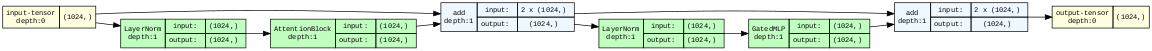

In [37]:
class GatedMLP(torch.nn.Identity):
    """Placeholder"""

class AttentionBlock(torch.nn.Identity):
    """Placeholder"""

display_graph(RWKVBlock(), input_data=torch.zeros(N_EMBD), depth=1)

Also, note use of residual connections: follow the arrow at the top -- just additions!

Better for optimization,
but also why we can rip out the middle of the architecture and still get reasonable behavior:
each block just slightly adjusts the outputs of the previous block, until we get to the end and predict.

Speaking of multiple blocks!

To fit this in our `RWKVLM` interface, we'll combine multiple `RWKVBlock`s into a single `Module`.

In [38]:
class RWKV(LoadingMixin, torch.nn.Module):

    @beartype
    def forward(self, x: Embedding) -> Embedding:
        for ii, block in enumerate(self.blocks):
            x = block(x)
        return x

In [39]:
def __init__(self, rwkv_blocks: list[RWKVBlock]):
    super(RWKV, self).__init__()
    self.blocks = torch.nn.Sequential(*rwkv_blocks)

RWKV.__init__ = __init__

## "Channel-Mixing" aka an MLP with gating

In [40]:
class GatedMLP(torch.nn.Module):
    """Applies an MLP (matrix, nonlinearity, matrix) with gated outputs."""

    @beartype
    def forward(self, x: Embedding) -> Update:
        # "mix" current input with previous input
        mixed_x: Embedding = self.mlp_mixer(x)
        # put that through an MLP
        mlp_outputs: Embedding = self.value(self.nonlinearity(self.key(mixed_x)))  # non-standard nomenclature, probably because of this paper https://arxiv.org/abs/2012.14913

        # "mix" the current input with the previous input again, with different weights
        mixed_x_receptance: Embedding = self.receptance_mixer(x)
        # use that to calculate how "receptive" each dimension of embedding is to new inputs
        receptance: Embedding = self.receptance(mixed_x_receptance)

        # convert that receptance to a 0-1 value with a sigmoid, then use those as "gating"
        gating_values: Embedding = torch.nn.functional.sigmoid(receptance)
        dx: Update = gating_values * mlp_outputs

        return dx

What do we mean by "mix current input with previous input"?

In [41]:
class Mixer(LoadingMixin, torch.nn.Module):
    """Returns a per-entry-weighted combination of current input and previous input."""

    @beartype
    def forward(self, current_x: Embedding) -> Embedding:
        out =  mix_embeddings(current_x, self.last_x, self.weight)
        self.last_x: Embedding = current_x  # store for later
        return out

In [42]:
EmbeddingwiseParam = Float[torch.Tensor, f"params={N_EMBD}"]  # one parameter for each embedding dimension
@beartype
def mix_embeddings(x: Embedding, y: Embedding, mixing_params: EmbeddingwiseParam) -> Embedding:
    """Mixes two embeddings with weights given by the mixing_params."""
    return x * mixing_params + y * (1 - mixing_params)

But where does that come from?

We use `register_buffer` to store extra information in our `torch.nn.Module` --
kinda like declaring a `Parameter`, but without the gradients.

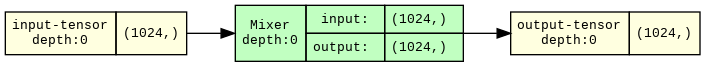

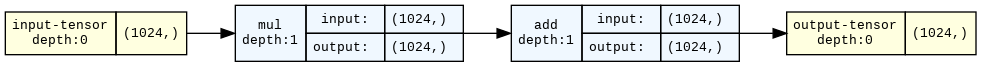

In [43]:
def __init__(self):
    super(Mixer, self).__init__()
    self.weight = torch.nn.Parameter(torch.zeros(N_EMBD))
    self.register_buffer("last_x", torch.zeros(N_EMBD), persistent=False)

Mixer.__init__ = __init__

for depth in range(2):
    display_graph(Mixer(), input_data=torch.zeros(N_EMBD), depth=depth)

Now, we can round our our `GatedMLP` implementation:

In [44]:
MLP_HIDDEN_DIM = 4096

def __init__(self):
    super(GatedMLP, self).__init__()
    # non-standard terminology of RWKV: "key" is first layer of MLP, "value" is second
    self.key = torch.nn.Linear(N_EMBD, MLP_HIDDEN_DIM, bias=False)
    self.nonlinearity = SquaredReLU()  # non-standard nonlinearity
    self.value = torch.nn.Linear(MLP_HIDDEN_DIM, N_EMBD, bias=False)

    self.mlp_mixer, self.receptance_mixer = Mixer(), Mixer()
    self.receptance = torch.nn.Linear(N_EMBD, N_EMBD, bias=False)

GatedMLP.__init__ = __init__

Yeah, the nonlinearity is non-standard too:

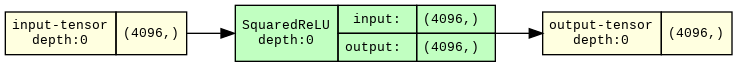

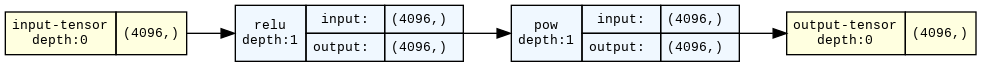

In [45]:
Latents = Float[torch.Tensor, f"latents={MLP_HIDDEN_DIM}"]

class SquaredReLU(torch.nn.Module):
    def forward(self, x: Latents) -> Latents:
        return torch.nn.functional.relu(x) ** 2

for depth in range(2):
    display_graph(SquaredReLU(), input_data=torch.zeros(MLP_HIDDEN_DIM), depth=depth)

Altogether:

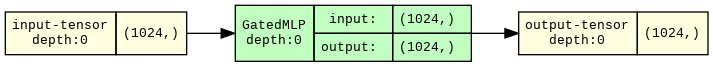

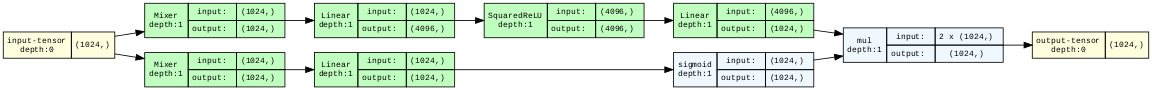

In [46]:
for depth in range(2):
    display_graph(GatedMLP(), depth=depth, input_data=torch.zeros(N_EMBD))

## "Time-Mixing" aka Attention

TODO: write a bit more on this part

In [47]:
from torch import exp, sigmoid


class AttentionBlock(torch.nn.Module):

    @beartype
    def forward(self, x: Embedding) -> Update:
        # TODO: not sure calling these "keys" is that sensible actually -- there's no dot product!
        mixed_keys = self.key_mixer(x)
        k: Embedding = self.key(mixed_keys)

        mixed_vals = self.value_mixer(x)
        v: Embedding = self.value(mixed_vals)

        # take our keys and values and merge them with what we've seen so far
        wkv: Embedding = self.memory(k, v)

        # decide how receptive each channel is to inputs
        mixed_receptances = self.receptance_mixer(x)
        r: Embedding = self.receptance(mixed_receptances)
        gating_values = sigmoid(r)

        # gate the output of the memory
        rwkv: Embedding = gating_values * wkv

        # and then do one final linear layer before returning it
        dx: Update = self.output(rwkv)

        return dx

In [48]:
def __init__(self):
    super(AttentionBlock, self).__init__()

    # linear operations
    self.key = torch.nn.Linear(N_EMBD, N_EMBD, bias=False)
    self.value = torch.nn.Linear(N_EMBD, N_EMBD, bias=False)
    self.receptance = torch.nn.Linear(N_EMBD, N_EMBD, bias=False)
    self.output = torch.nn.Linear(N_EMBD, N_EMBD, bias=False)

    # mixers
    self.key_mixer, self.value_mixer = Mixer(), Mixer()
    self.receptance_mixer = Mixer()

    # memory
    self.memory = WKVMemory()


AttentionBlock.__init__ = __init__

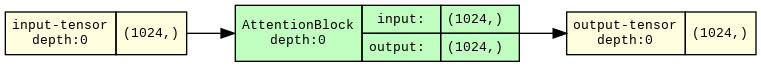

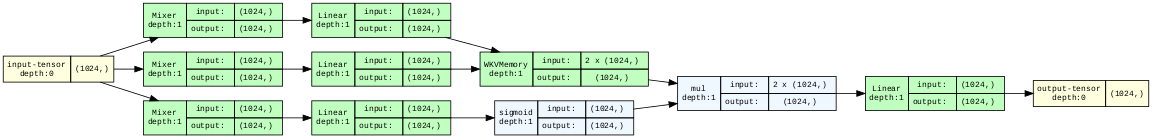

In [49]:
class WKVMemory(torch.nn.Module):
    """Placeholder"""
    def forward(self, k, v):
        return k


for depth in range(2):
    display_graph(AttentionBlock(), depth=depth, input_data=torch.zeros(N_EMBD))

Okay, so what's the `memory` really doing?

In [50]:
EmbeddingScaler = Float[torch.Tensor, f"positiveValues={N_EMBD}"]  # all entries are > 0

class WKVMemory(torch.nn.Module):
    """A memory module whose contents exponentially decay over time, at a different rate per dimension."""

    def forward(self, k, v):
        # decay the information currently memory by one step
        decay_rate = exp(self.log_decay)  # ensures that decay rate is positive, so we forget the past
        self.contents = exp(-decay_rate) * self.contents
        self.normalizer = exp(-decay_rate) * self.normalizer

        update_values = exp(k) * v  # scale all of our values by their (exponentiated) keys
        update_normalizer: EmbeddingScaler = exp(k)  # keep track of so that values don't grow too large

        # then add the new information to the memory -- including updating the normalizer that keeps values from exploding
        self.contents = self.contents + update_values
        self.normalizer = self.normalizer + update_normalizer

        # fun bonus: we add a "gain" to the latest token before computing the outputs,
        #  so that it's always treated differently

        # the larger the value of the gain on that channel, the more that that channel's output looks like the values
        # at the very smallest, the gain is -1, which immediately removes the values we just added
        gain = exp(self.log_gain) - 1

        # apply a gain to the new inputs before computing output by applying our normalizer
        wkv = (self.contents + gain * update_values) /  \
              (self.normalizer + gain * update_normalizer)

        return wkv

Yeah, it's weird.

In [51]:
def __init__(self):
    super(WKVMemory, self).__init__()

    # channel-wise memory parameters
    self.log_gain = torch.nn.Parameter(torch.zeros(N_EMBD))
    self.log_decay = torch.nn.Parameter(torch.zeros(N_EMBD))

    # persistent state
    contents, normalizer = torch.zeros(N_EMBD), torch.zeros(N_EMBD)
    self.register_buffer("contents", contents, persistent=False)
    self.register_buffer("normalizer", normalizer, persistent=False)

WKVMemory.__init__ = __init__

# Putting it all together

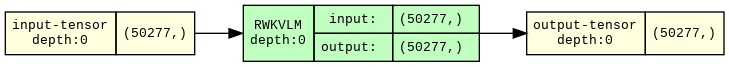

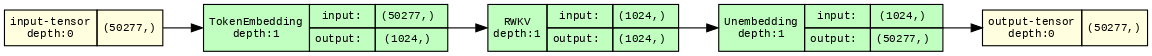

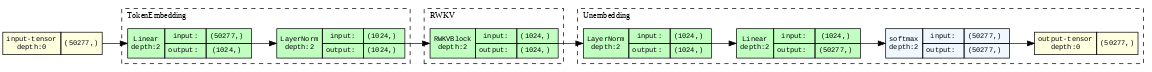

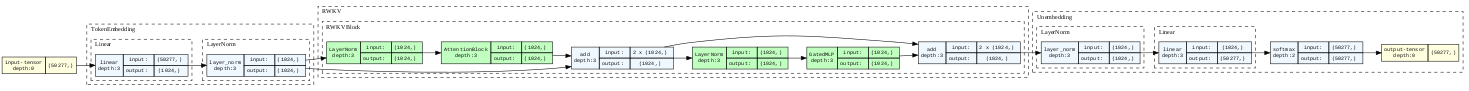

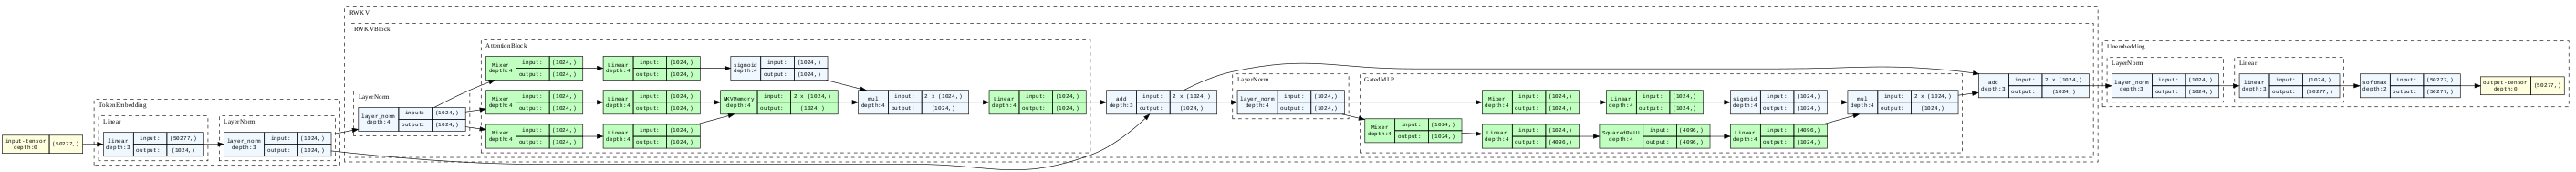

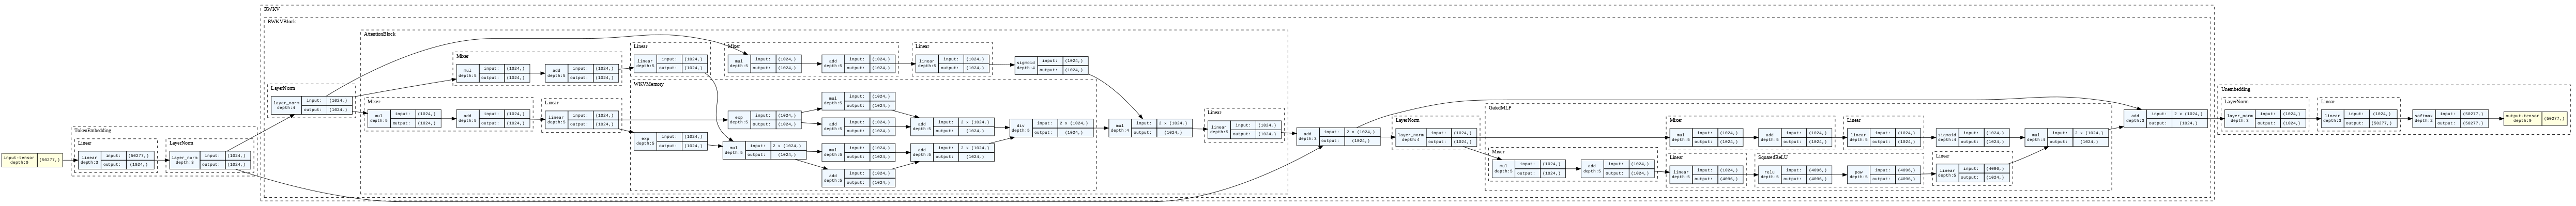

In [52]:
for depth in range(6):
    display_graph(RWKVLM(TokenEmbedding(), RWKV([RWKVBlock()]), Unembedding()), depth=depth)

Easy-peasy.

Let's run a few layers and see if the added ability to store information about past tokens
solves the fly in our truffle ointment:

In [53]:
k = 2
short_rwkv = RWKV.from_weights(weights, [RWKVBlock() for _ in range(2)])
short_rwkvlm = RWKVLM(embs, short_rwkv, unembs)
short_rwkvlm = short_rwkvlm.eval()

out = short_rwkvlm.generate(context="Drosophila", N=2, temperature=0.0)

Preprocessing context
Drosophila melanog

Success!


But those buffers are accumulating state between runs.

Let's add something to clear that out.

In [54]:
def clear_buffers(module, verbose=False):
    for name, buffer in module.named_buffers():
        if verbose:
            print(f"clearing buffer {name}")
        buffer.zero_()


RWKV.clear_buffers = clear_buffers
RWKVBlock.clear_buffers = clear_buffers
RWKVLM.clear_buffers = clear_buffers

# Running a "Real" Language Model

Now let's do the whole model.

In [55]:
N_LAYER = 24
rwkv_blocks = [RWKVBlock() for _ in range(N_LAYER)]

In [56]:
rwkv = RWKV.from_weights(weights, rwkv_blocks)

rwkvlm = RWKVLM(embs, rwkv, unembs)
rwkvlm = rwkvlm.eval()

In [57]:
rwkvlm.clear_buffers()

out = rwkvlm.generate(context="Drosophila", N=8, temperature=0.0)

Preprocessing context
Drosophila* and *Drosophila melanogaster*

Interestingly, it starts adding some Markdown formatting --
scientific names are usually written *Like this*,
which is formatted in Markdown `*Like this*`.

For comparison with the official implementation, we run their prompt.

In [58]:
rwkvlm.clear_buffers()

context = """
In a shocking finding, scientist discovered a herd of dragons living in a remote, previously unexplored valley, in Tibet. """ + \
"Even more surprising to the researchers was the fact that the dragons spoke perfect Chinese."

rwkvlm.generate(context, N=20, temperature=0.0, top_p=1.0);

Preprocessing context

In a shocking finding, scientist discovered a herd of dragons living in a remote, previously unexplored valley, in Tibet. Even more surprising to the researchers was the fact that the dragons spoke perfect Chinese.

The dragons were discovered by a team of researchers from the University of California, Berkeley, who

Go Bears.